In [1]:
import numpy as np
import pandas as pd
import sys; sys.path.append("..")
from trader.backtest.pnl import PnL
from trader.strategies.breakout import breakout
from trader.strategies.cp_trend import cp_trend
from trader.strategies.vol_trend import vol_trend


In [96]:
bars = pd.read_csv("daily.csv")
bars = bars[bars.CloseTime >= "2022-01-01"]
prices = bars.pivot(index="CloseTime", columns = "Symbol", values="Close")
volumes = bars.pivot(index="CloseTime", columns = "Symbol", values="Volume")

In [97]:
price = prices.BTCUSDT
volume = volumes.BTCUSDT

In [98]:
s1 = breakout(price, 30)
s2 = cp_trend(price)
s3 = vol_trend(price, volume, 8, 32)
s4 = vol_trend(price, volume, 16, 64)
s5 = vol_trend(price, volume, 32, 128)

<AxesSubplot:xlabel='CloseTime'>

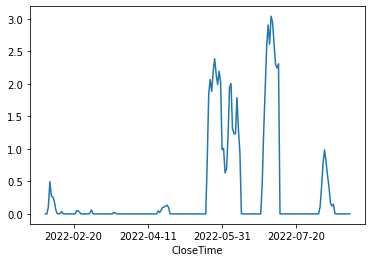

In [99]:
s3.plot()

In [116]:
fors = pd.concat({"break" : s1, "cp" : s2, "vol1" : s3, "vol2" : s4, "vol3" : s5}, axis=1)

In [125]:
class MultiForecast:
    """
    forecasts - dataframe with columns is strategy_parameters
    prices is series
    """
    def __init__(self, forecasts, price):
        self.forecasts = forecasts
        self.price = price
    
    def get_pnls(self):
        pnls = {}
        for col in self.forecasts.columns:
            forecast = self.forecasts.loc[:, col]
            pnls[col] = PnL(forecast, price).pnl
        return pd.concat(pnls, axis=1)

    def combine(self):
        pnls = self.get_pnls()
        stds = 1/ pnls.std()
        w = stds / stds.sum()
        self.weights = w
        return self.forecasts.dot(w)

In [126]:
mf = MultiForecast(fors, price)
pnls = mf.get_pnls()

In [133]:
w = 1/pnls.std()
w

break     14.819822
cp        14.762666
vol1     175.643029
vol2     631.698018
vol3            inf
dtype: float64

In [127]:
e = np.ones(pnls.shape[1])
inv = np.linalg.pinv(pnls.cov())
w = e.dot(inv) / (e.T.dot(inv).dot(e))

In [128]:
pd.Series(w, index=pnls.columns)

break    0.000652
cp      -0.000154
vol1    -0.065688
vol2     1.065190
vol3     0.000000
dtype: float64

<AxesSubplot:xlabel='CloseTime'>

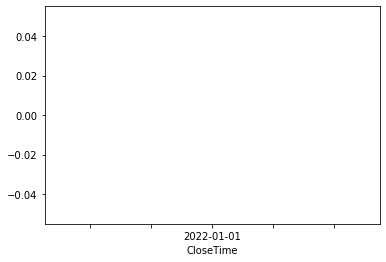

In [129]:
mf.combine().plot()

In [130]:
mf.weights

break    0.0
cp       0.0
vol1     0.0
vol2     0.0
vol3     NaN
dtype: float64

<AxesSubplot:xlabel='CloseTime'>

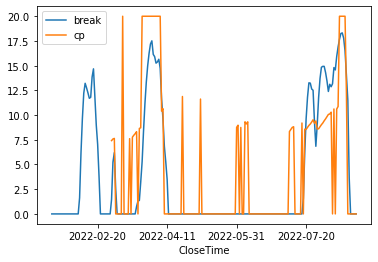

In [104]:
fors.plot()

<AxesSubplot:xlabel='CloseTime'>

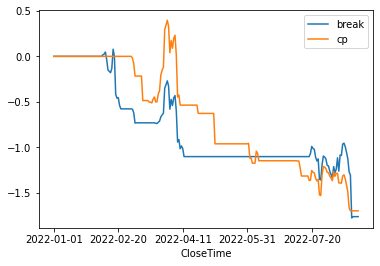

In [105]:
pnls.cumsum().plot()

In [49]:
w = pnls.std()
w /= w.sum()

In [61]:
w

break    0.358782
cp       0.407288
vol1     0.055671
vol2     0.068612
vol3     0.109646
dtype: float64

<AxesSubplot:xlabel='CloseTime'>

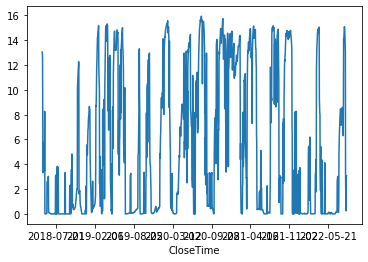

In [53]:
fors.dot(w).plot()

In [59]:
PnL(fors.dot(w), price).pnl.std()

0.10895353649402233

In [60]:
pnls.std()

break    0.132791
cp       0.150744
vol1     0.020605
vol2     0.025395
vol3     0.040582
dtype: float64